## RDD figure 1

Imports

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model

from lib.lif import LIF, ParamsLIF
from lib.causal import causaleffect, causaleffect_linear

Populating the interactive namespace from numpy and matplotlib


In [48]:
#Load simulations and compute different average cost functions
N = 19
nsims = 1
c = 0.75
T = 500000
deltaT = 50

fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_deltaT_simulations.npz'%(N, nsims, c)
sims = np.load(fn_in)
hs = sims['hs']
vs = sims['vs']

#Pretty slowly firing...
i = 3;
j = 3;
h1 = hs[i,j,0,0,0:T]
v1 = vs[i,j,0,0,0:T]
h2 = hs[i,j,0,1,0:T]
v2 = vs[i,j,0,1,0:T]

tau_s = 0.2
t_filter = np.linspace(0, 2, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]
s1 = np.convolve(h1, exp_filter)[0:len(h1)]
s2 = np.convolve(h2, exp_filter)[0:len(h1)]

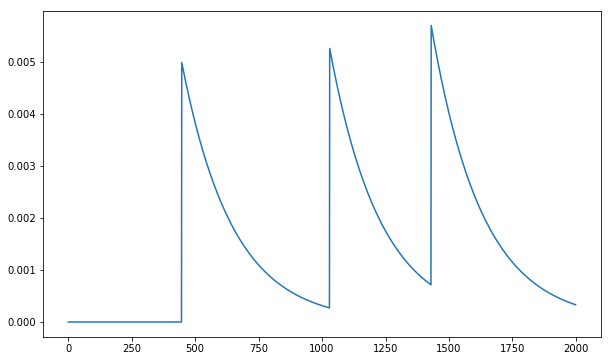

In [49]:
plt.plot(s1[0:2000])

In [50]:
x=3
alpha1 = 80
alpha2 = -40
mu = 1

v1 = vs[i,j,0,0,0:T]
v2 = vs[i,j,0,1,0:T]

#Compute a cost function
cost_s = (alpha1*s1+alpha2*s2-x**2)**2

#Block voltage output and cost function
cost_s_r = cost_s.reshape((-1, deltaT))
v1_r = v1.reshape((-1, deltaT))
v2_r = v2.reshape((-1, deltaT))

#Take max voltage in each block, take cost at end of block
v1 = np.max(v1_r, 1)
v2 = np.max(v2_r, 1)
cost_s = np.squeeze(cost_s_r[:,-1])

print(v2.shape)
print(cost_s.shape)

#Compute the causal effect
p = 0.05
abv = (v1>mu) & (v1<(mu+p))
blo = (v1<mu) & (v1>(mu-p))
C_abv = cost_s[abv]
C_blo = cost_s[blo]
mu_1_blo = np.mean(C_blo)
mu_1_abv = np.mean(C_abv)

abv = (v2>mu) & (v2<(mu+p))
blo = (v2<mu) & (v2>(mu-p))
C_abv = cost_s[abv]
C_blo = cost_s[blo]
mu_2_blo = np.mean(C_blo)
mu_2_abv = np.mean(C_abv)

beta_1 = mu_1_abv-mu_1_blo
beta_2 = mu_2_abv-mu_2_blo

(10000,)
(10000,)


In [51]:
#Compute some regression lines
#lr = KernelRidge(kernel = 'rbf', gamma=1e-6, alpha=1e-2)
lr = linear_model.LinearRegression()

x0ltMu = v1[v1<mu]
lr.fit(x0ltMu.reshape(-1,1), cost_s[v1<mu].reshape(-1,1)) 
x0ltMu.sort()
y0ltMu = lr.predict(x0ltMu.reshape(-1,1))
y0lt_thr = lr.predict(1)

x1ltMu = v2[v2<mu]
lr.fit(x1ltMu.reshape(-1,1), cost_s[v2<mu].reshape(-1,1)) 
x1ltMu.sort()
y1ltMu = lr.predict(x1ltMu.reshape(-1,1))
y1lt_thr = lr.predict(1)

x0gtMu = v1[v1>mu]
lr.fit(x0gtMu.reshape(-1,1), cost_s[v1>mu].reshape(-1,1)) 
x0gtMu.sort()
y0gtMu = lr.predict(x0gtMu.reshape(-1,1))
y0gt_thr = lr.predict(1)

x1gtMu = v2[v2>mu]
lr.fit(x1gtMu.reshape(-1,1), cost_s[v2>mu].reshape(-1,1)) 
x1gtMu.sort()
y1gtMu = lr.predict(x1gtMu.reshape(-1,1))
y1gt_thr = lr.predict(1)

In [52]:
print("Unit 1")
print("mean causal effect constant model: %f"%beta_1)
print("mean causal effect linear model: %f"%(y0gt_thr-y0lt_thr))
print("Unit 2")
print("mean causal effect constant model: %f"%beta_2)
print("mean causal effect linear model: %f"%(y1gt_thr-y1lt_thr))

Unit 1
mean causal effect constant model: -5.783475
mean causal effect linear model: -5.598471
Unit 2
mean causal effect constant model: 2.145831
mean causal effect linear model: 1.755970


Make the plot

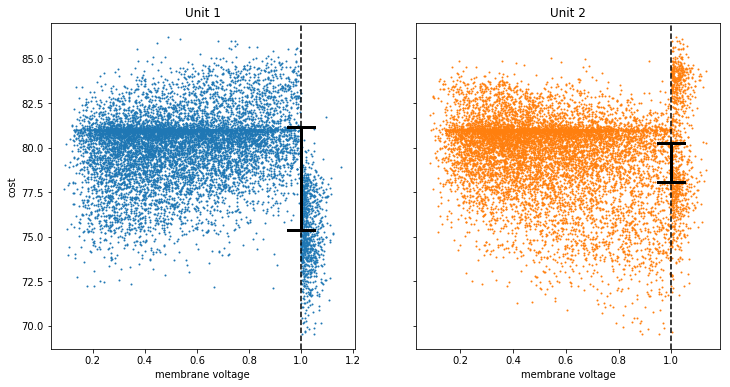

In [53]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(12,6))
ax1.plot(v1, cost_s, '.C0', markersize=2);
ax2.plot(v2, cost_s, '.C1', markersize=2);

ax1.set_title("Unit 1")
ax2.set_title("Unit 2")
ax1.set_xlabel("membrane voltage")
ax2.set_xlabel("membrane voltage")
ax1.set_ylabel("cost")

tkx = np.array([0.95, 1.05])

ax1.axvline(x=1, linestyle='--', color=(0,0,0))
ax2.axvline(x=1, linestyle='--', color=(0,0,0))

ax1.plot(tkx, mu_1_blo*np.ones(tkx.shape), color=(0,0,0), linewidth=3)
ax1.plot(tkx, mu_1_abv*np.ones(tkx.shape), color=(0,0,0), linewidth=3)
ax1.plot([1, 1], [mu_1_abv, mu_1_blo], color=(0,0,0), linewidth=3)
ax2.plot(tkx, mu_2_blo*np.ones(tkx.shape), color=(0,0,0), linewidth=3)
ax2.plot(tkx, mu_2_abv*np.ones(tkx.shape), color=(0,0,0), linewidth=3)
ax2.plot([1, 1], [mu_2_abv, mu_2_blo], color=(0,0,0), linewidth=3);

#ax1.plot(x0ltMu,y0ltMu,'C0',x0gtMu,y0gtMu, color=(0,0,0), linewidth=3);
#ax2.plot(x1ltMu,y1ltMu,'C1',x1gtMu,y1gtMu, color=(0,0,0), linewidth=3);

#plt.savefig('./fig_1a.pdf')

Also make the probability of firing graph.

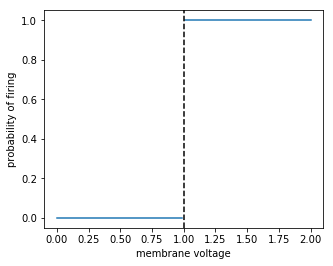

In [2]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
N = 100
x = np.linspace(0,2,N)
y = np.hstack((np.zeros(N/2), np.ones(N/2)))
ax.plot(x[0:50], y[0:50], 'C0', x[50:100], y[50:100], 'C0')
ax.set_xlabel('membrane voltage')
ax.set_ylabel('probability of firing')
ax.axvline(x=1, linestyle='--', color=(0,0,0))
plt.savefig('./fig_1b.pdf')

Make counter factual diagrams.

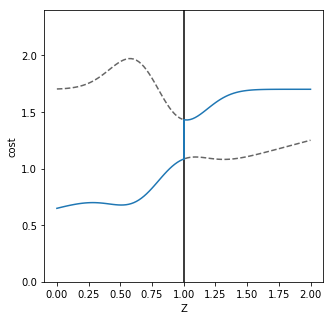

In [3]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

y1 = np.exp(-10*(x-.8)**2)*(x-.8)+0.65+.3*x
y2 = -2*np.exp(-10*(x-.8)**2)*(x-.8)+1.7
ax.plot(x[0:50],y1[0:50], 'C0')
ax.plot(x[0:50],y2[0:50], '--', color=(0.4,0.4,0.4))
ax.plot(x[50:100],y1[50:100], '--', color=(0.4,0.4,0.4))
ax.plot(x[50:100],y2[50:100], 'C0')
ax.set_xlabel('Z')
ax.set_ylabel('cost')
ax.axvline(x=1, color=(0,0,0))
ax.set_ylim([0, 2.4])
ax.plot([1, 1], [y1[50], y2[50]], 'C0', linewidth=2);
plt.savefig('./fig_1c.pdf')